# Linear Random Forest

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lineartree import LinearTreeRegressor
from sklearn.metrics import root_mean_squared_error
import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import time

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression
from notebooks.utils.lrf import LinearRandomForestRegressor

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/house_prices.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/house_prices.parquet')

In [5]:
y_train = train.SalePrice
X_train = train.drop(columns=['SalePrice'])

In [6]:
y_validation = validation.SalePrice
X_validation = validation.drop(columns=['SalePrice'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
y_train_scaled = y_train/1000
y_validation_scaled = y_validation/1000

In [10]:
n_estimators = [2, 5, 8, 11, 15, 20, 25, 30]

In [20]:
max_depth = [1, 2, 3, 4, 5, 7, 10]
base_mod = [LinearRegression(), Ridge()]

In [21]:
base_est = []
for i in max_depth:
    for mod in base_mod:
        base_est.append(LinearTreeRegressor(base_estimator=mod, max_depth=i))

In [22]:
models_list = []
names_list = []
for n in n_estimators:
    for estim in base_est:
        models_list.append(LinearRandomForestRegressor(n_features=X_train.shape[1], est=estim, n_est=n))
        if isinstance(estim.base_estimator, LinearRegression):
            names_list.append(f'LRF_{n}_{estim.max_depth}')
        elif isinstance(estim.base_estimator, Ridge):
            names_list.append(f'LRF_{n}_{estim.max_depth}_l2')

In [23]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/house_prices/lrf.csv', X_train_scaled, y_train_scaled, X_validation_scaled, y_validation_scaled)
metrics.sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LRF_2_4_l2,0.497447,36.189230,36.984222,2.196761
LRF_5_3_l2,0.986966,38.118948,43.086564,13.031883
LRF_5_7_l1,1.473976,36.978305,43.291587,17.072933
LRF_2_10_en_0.25,0.142543,41.194048,44.408085,7.802189
LRF_2_10_l2,0.556314,41.204551,44.643316,8.345595
...,...,...,...,...
LRF_11_5,2.398038,70628.343509,166927.188635,136.345892
LRF_11_2,1.529358,92412.713414,233488.883421,152.658833
LRF_30_5,4.918420,96322.889903,366735.548192,280.735616
LRF_20_2,3.267013,139098.562567,428919.463191,208.356503


We choose **LRF_2_4_l2** as the best one.

In [24]:
test =  pd.read_parquet('../../../data/model_input/test_sets/house_prices.parquet')

In [25]:
y_test = test.SalePrice
X_test = test.drop(columns=['SalePrice'])

In [26]:
retrain = pd.concat([train, validation])

In [27]:
y_retrain = retrain.SalePrice
X_retrain = retrain.drop(columns=['SalePrice'])

In [28]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [29]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [30]:
y_retrain_scaled = y_retrain/1000
y_test_scaled = y_test/1000

In [57]:
time1 = time.time()
model = LinearRandomForestRegressor(n_features=X_retrain.shape[1], est=LinearTreeRegressor(base_estimator=Ridge(), max_depth=4), n_est=2).fit(X_retrain_scaled, y_retrain_scaled)
time2 = time.time() - time1

In [58]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test_scaled, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 28.8036


In [59]:
train_pred = model.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain_scaled, train_pred)

In [60]:
with open('../../../data/model_output/metrics/house_prices/final_metrics.txt', 'a') as f:
     f.write(f'\nLRF; {time2}; {rmse_train}; {rmse}')

In [61]:
dump(model, '../../../data/model_output/models/house_prices/best_lrf.joblib')

['../../../data/model_output/models/house_prices/best_lrf.joblib']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_8096/3753368203.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],


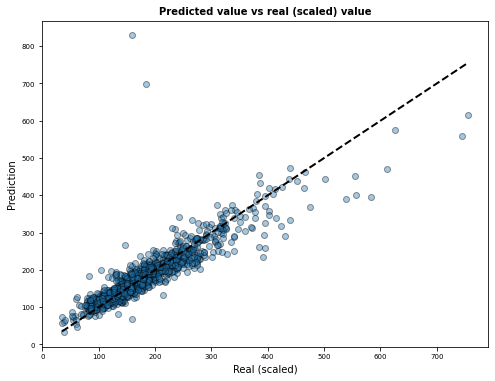

In [63]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain_scaled

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain_scaled, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)